# Phase Picking of Denoised DAS

In [1]:
import gc
import h5py
import torch
import numpy as np
import torch.nn as nn
from das_util import try_gpu
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.signal import filtfilt, butter
from torch.utils.data import DataLoader
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from sklearn.model_selection import train_test_split

## 1. Read and pre-filter the benchmark data

Use the __seismo__ ipykernel on **Siletzia** for two reasons:

1. It has GPUs

2. It stores AK-DAS data

In [2]:
! du -sh /fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023*

8.3G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_22.hdf5
3.8G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5
5.2G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_12.hdf5
5.4G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_16.hdf5
11G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_18.hdf5
24G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_02.hdf5
24G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_11.hdf5


In [17]:
### Read (change the file to the latest if needed)
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_07_29.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['quake'][:]

In [18]:
### Filter
sample_rate = 25
delta_space = 10

rawdata = np.append(quake2[:,:1500,:], quake1[:,:1500,:], axis=0)
b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt = filtfilt(b, a, rawdata, axis=2)
rawdata = filt / np.std(filt, axis=(1,2), keepdims=True)  ## Rawdata w.r.t. Denoised 

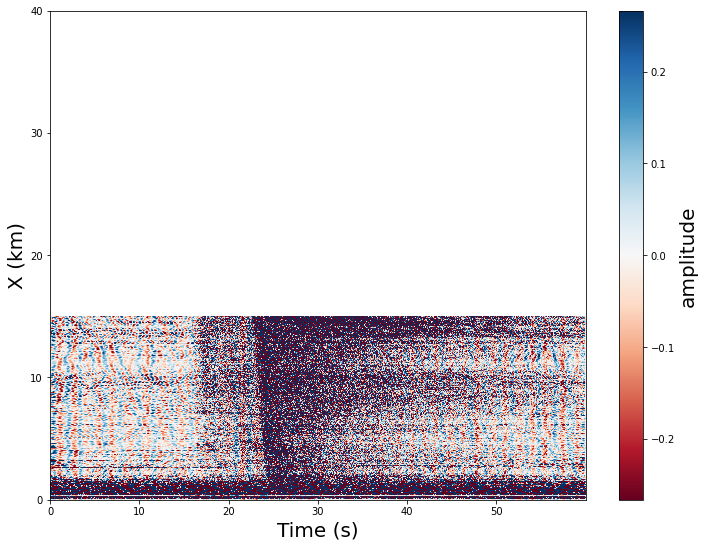

In [19]:
### visualize example data
time_data = rawdata[5]
max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])

plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu')
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
plt.yticks(np.arange(0, 4500, 1000), (np.arange(0, delta_space*4500, 1000*delta_space)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

## 2. Select a portion of the data for testing

In [4]:
### Shuffle and split dataset
X_tr, X, Y_tr, Y = train_test_split(rawdata, rawdata,
                                        train_size=0.7,
                                        random_state=111)
X_va, X_te, Y_va, Y_te = train_test_split(X, Y,
                                        train_size=0.5,
                                        random_state=121)

### If in=label
# test_data = dataflow(X_te[:,500:2000,:], stride=1500, n_masks=1) 
### If in!=label
test_data = datalabel(X_te[:,500:2000,:], Y_te[:,500:2000,:], mask_ratio=0.8)

del X, Y, rawdata
gc.collect()
print(len(test_data))

KeyboardInterrupt: 

## 3. Load models trained in different ways

In [6]:
""" Initialize the U-net model """
devc = try_gpu(i=0)

model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1 = nn.DataParallel(model_1, device_ids=[0,1,2,3])
model_1.to(devc)
model_1.load_state_dict(torch.load('models/checkpoint_noatt_LRdecays0.8_mask0.3.pt'))  # raw2raw
model_1.eval() 

model_2 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_2 = nn.DataParallel(model_2, device_ids=[0,1,2,3])
model_2.to(devc)
model_2.load_state_dict(torch.load('models/checkpoint_noatt_LRdecays0.8_mask0.5_fk2fk.pt'))  # fk2fk
model_2.eval() 

model_3 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_3 = nn.DataParallel(model_3, device_ids=[0,1,2,3])
model_3.to(devc)
model_3.load_state_dict(torch.load('checkpoint.pt'))  # raw2fk
model_3.eval() 

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

## 4. Denoise to compare

In [24]:
### convert to torch tensors
# (X, mask), y = test_data[:100]
# X = torch.from_numpy(X).to(devc)

X=rawdata[:100,:,:].astype(np.float32)
X = torch.from_numpy(X).to(devc)
### denoise
with torch.no_grad():
    ### raw2raw
    oneDenoise_1 = model_1(X)
    mulDenoise_1 = model_1(oneDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)

    ### fk2fk
    oneDenoise_2 = model_2(X)
    mulDenoise_2 = model_2(oneDenoise_2)
    mulDenoise_2 = model_2(mulDenoise_2)
    mulDenoise_2 = model_2(mulDenoise_2)

    ### raw2fk
    oneDenoise_3 = model_3(X)
    mulDenoise_3 = model_3(oneDenoise_3)

### convert back to numpy, trim edges
rawdata = X.to('cpu').numpy()
oneDenoise_1 = oneDenoise_1.to('cpu').numpy()
oneDenoise_2 = oneDenoise_2.to('cpu').numpy()
oneDenoise_3 = oneDenoise_3.to('cpu').numpy()
mulDenoise_1 = mulDenoise_1.to('cpu').numpy()
mulDenoise_2 = mulDenoise_2.to('cpu').numpy()
mulDenoise_3 = mulDenoise_3.to('cpu').numpy()

### save denoised data to file
# with h5py.File('/fd1/QibinShi_data/akdas/qibin_data/' + 'raw_and_one_mul_denoise.hdf5', 'w') as f:
#     f.create_dataset("raw", data=rawdata)
#     f.create_dataset("raw2raw_oneDenoise", data=oneDenoise_1)
#     f.create_dataset("fk2fk_oneDenoise", data=oneDenoise_2)
#     f.create_dataset("raw2fk_oneDenoise", data=oneDenoise_3)
#     f.create_dataset("raw2raw_mulDenoise", data=mulDenoise_1)
#     f.create_dataset("fk2fk_mulDenoise", data=mulDenoise_2)
#     f.create_dataset("raw2fk_mulDenoise", data=mulDenoise_3)

In [25]:
print(rawdata.shape)
print(oneDenoise_1.shape)

(100, 1500, 1500)
(100, 1500, 1500)


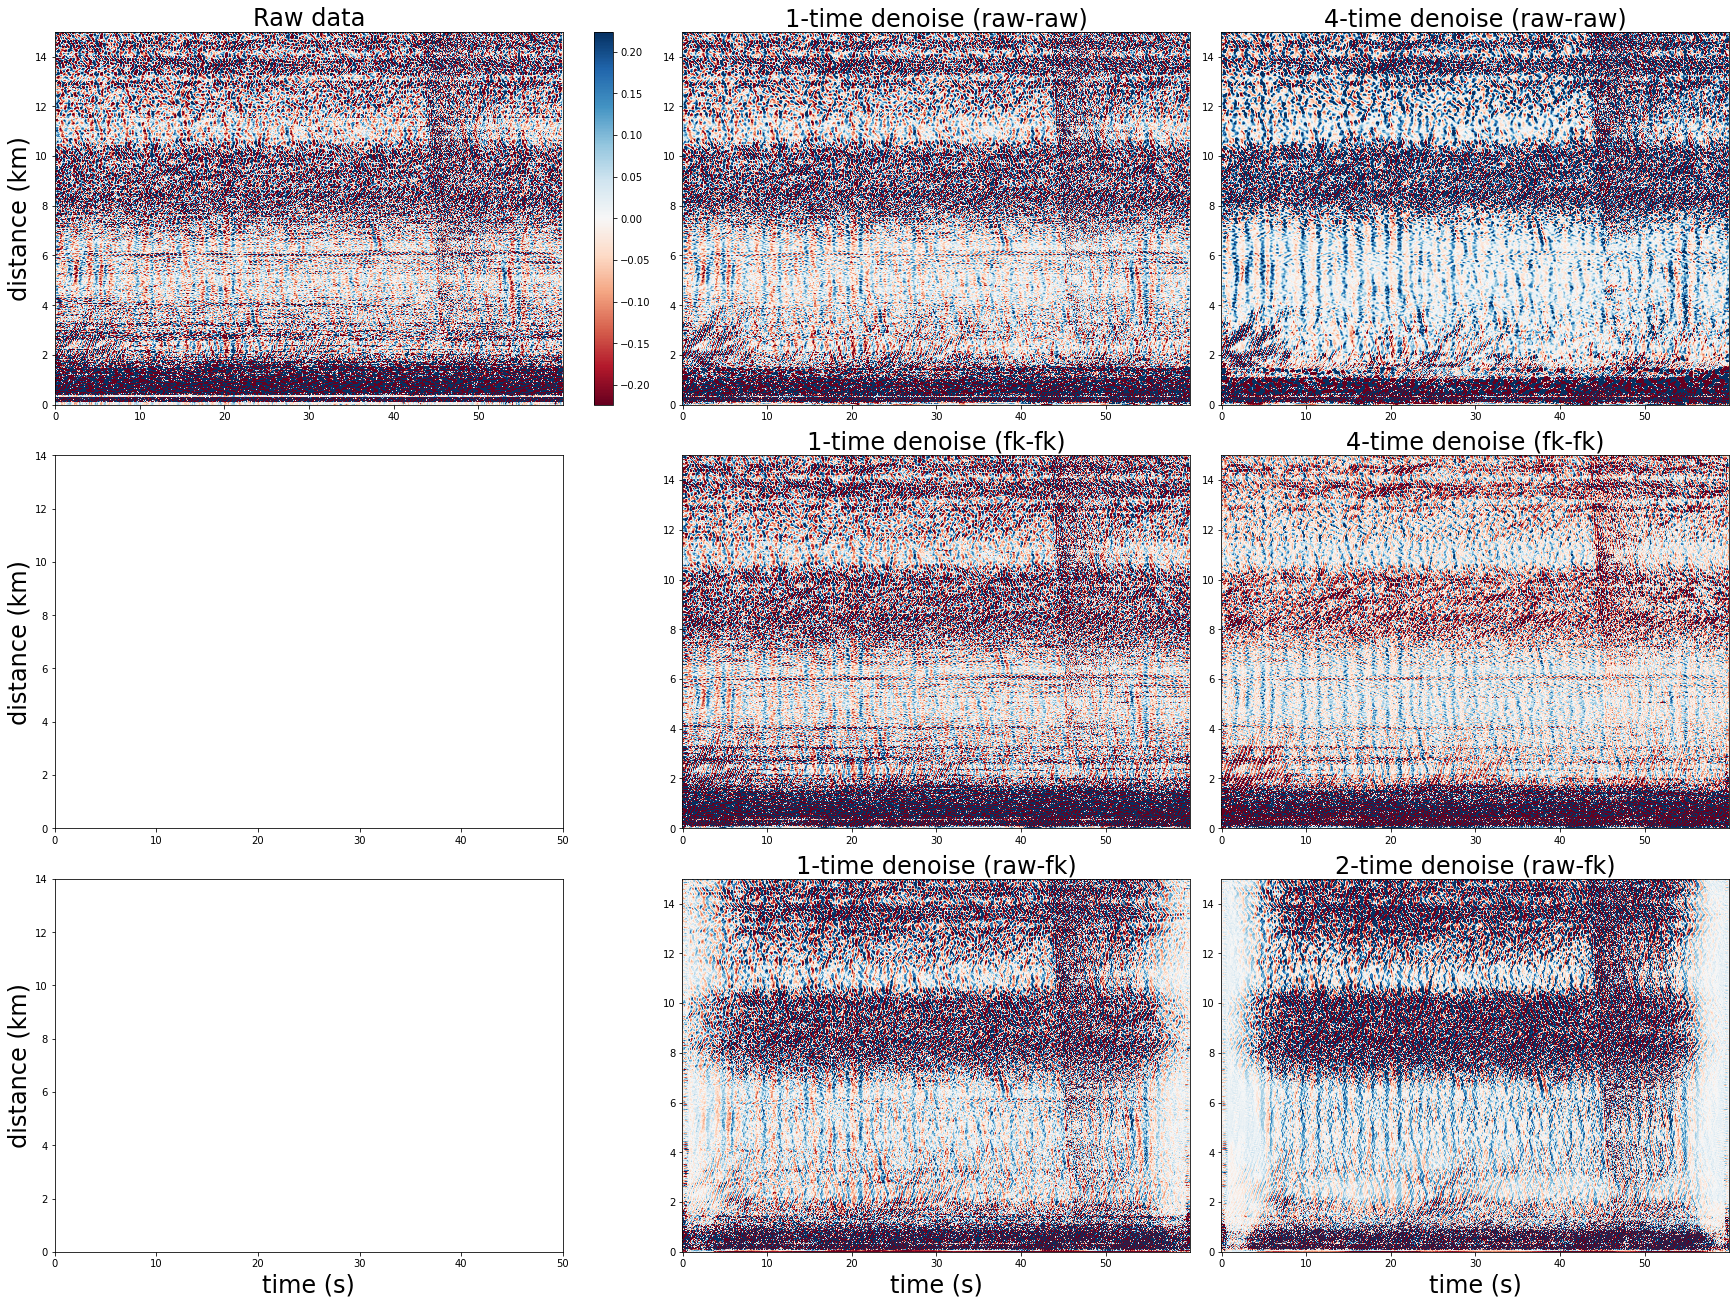

In [26]:
# visualize example data
for ind in np.arange(10,11):

    max_amp = np.median(np.fabs(rawdata[ind]))*2
    x, y = np.arange(rawdata[ind].shape[1]), np.arange(rawdata[ind].shape[0])
    fig, ax = plt.subplots(3, 3, figsize=(24, 18), constrained_layout=True)

    ax[0,1].pcolormesh(x, y, oneDenoise_1[ind], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[0,1].set_title("1-time denoise (raw-raw)", fontsize=24)

    ax[1,1].pcolormesh(x, y, oneDenoise_2[ind], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[1,1].set_title("1-time denoise (fk-fk)", fontsize=24)

    ax[2,1].pcolormesh(x, y, oneDenoise_3[ind], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[2,1].set_title("1-time denoise (raw-fk)", fontsize=24)

    ax[0,2].pcolormesh(x, y, mulDenoise_1[ind], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[0,2].set_title("4-time denoise (raw-raw)", fontsize=24)

    ax[1,2].pcolormesh(x, y, mulDenoise_2[ind], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[1,2].set_title("4-time denoise (fk-fk)", fontsize=24)

    ax[2,2].pcolormesh(x, y, mulDenoise_3[ind], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    ax[2,2].set_title("2-time denoise (raw-fk)", fontsize=24)

    img=ax[0,0].pcolormesh(x, y, rawdata[ind], shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
    plt.colorbar(img, ax=ax[0,0])
    ax[0,0].set_title("Raw data", fontsize=24)

    for i in range(3):
        ax[2,i].set_xlabel('time (s)', fontsize=24)
        ax[i,0].set_ylabel('distance (km)', fontsize=24)
        for j in range(3):
            ax[i,j].set_xticks(np.arange(0, 1500, 250)) 
            ax[i,j].set_xticklabels(np.arange(0, 1500/sample_rate, 250/sample_rate).astype(int))
            ax[i,j].set_yticks(np.arange(0, 1500, 200))
            ax[i,j].set_yticklabels((np.arange(0, delta_space*1500, 200*delta_space)/1000).astype(int))

# Phase picking

### Read the denoised data (if you don't run the cells above)

In [74]:
### Read denoised data from file
### Each of the data variable is a numpy array: 
### [#images, #components, #space_channels, #time_points]  -- [100, 1, 1500, 1250]

with h5py.File('/fd1/QibinShi_data/akdas/qibin_data/' + 'raw_and_one_mul_denoise.hdf5', 'r') as f:
    rawdata = f["raw"][:]
    oneDenoise_1 = f["raw2raw_oneDenoise"][:]
    oneDenoise_2 = f["fk2fk_oneDenoise"][:]
    oneDenoise_3 = f["raw2fk_oneDenoise"][:]
    mulDenoise_1 = f["raw2raw_mulDenoise"][:]
    mulDenoise_2 = f["fk2fk_mulDenoise"][:]
    mulDenoise_3 = f["raw2fk_mulDenoise"][:]